# Měření vzdálenosti pomocí WiFi FTM

Provedl jsem experiment měření vzdálenosti pomocí WiFi standartu FTM. Měření bylo provedeno mezi dvěmi zařízeními ESP32-S3, které tento standart podporují.

Pro každou zvolenou vzdálenost je alespoň 80 měření, tudíž můžeme předpokládat, že chyba v měření vzdálenosti má normální rozdělení se střední hodnotou 0.

In [1]:
library(tidyverse)
library(viridis)
library(see)
library(ggdist)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite



In [2]:
pdf.options(encoding='ISOLatin2.enc')

In [3]:
distances <- c(1,2,3,4,5,6,7,8,9,10,12,14,16,18,20)
data <- list()
data_raw <- list()
for (distance in distances){
  name <- paste(distance, "m", sep="")
  tmp_data <- read.csv(file = paste("esp32-s3-data/ftm_main_", name, ".csv", sep=""))
  tmp_data$measurement_dist = rep(c(distance), each=length(tmp_data$index))
  tmp_data$dist_est = tmp_data$dist_est/100 # cm to m
  data <- rbind(data, tmp_data)
  tmp_data <- read.csv(file = paste("esp32-s3-data/ftm_raw_", name, ".csv", sep=""))
  tmp_data$measurement_dist = rep(c(distance), each=length(tmp_data$index))
  data_raw <- rbind(data_raw, tmp_data)
}

In [4]:
percentile_delta <- function(data, percentile){
  sample_mean <- mean(data)
  errors <- data - sample_mean
  p <- (1 - percentile)/2
  unbiasedSampleVariance <- sqrt((1/(length(errors)-1)) * sum(errors**2))
  delta <- (unbiasedSampleVariance/sqrt(length(errors))) * qt(p, length(errors)-1)
  return(abs(delta))
}

In [5]:
data_sd <- data %>%
  group_by(measurement_dist) %>%
  summarise(delta = percentile_delta(dist_est, 0.95), mean_dist_est=mean(dist_est))

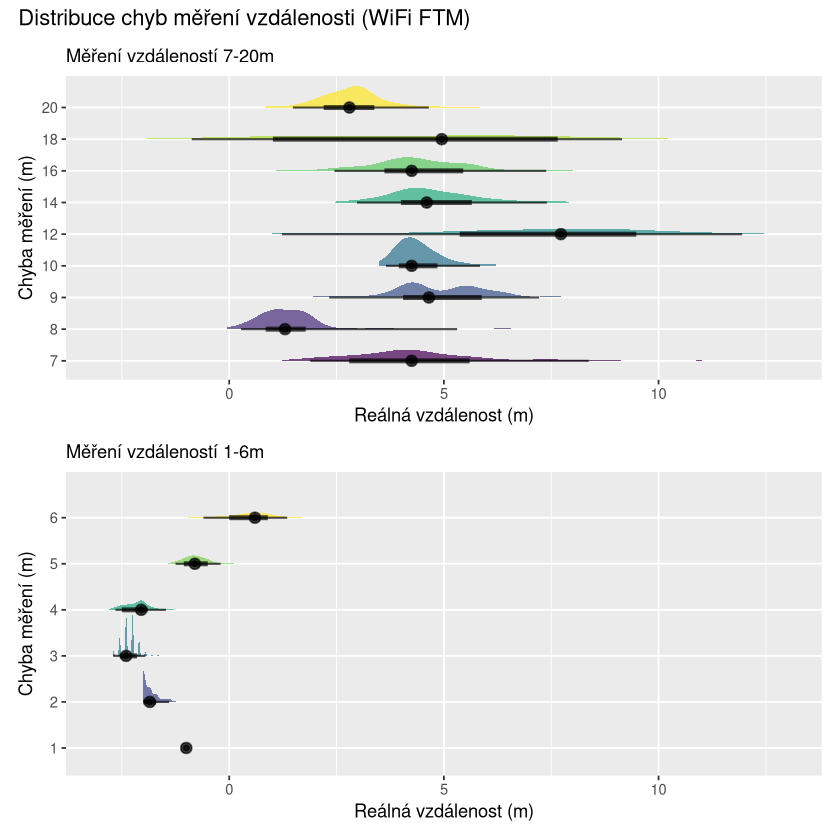

In [6]:
data_normalized <- data %>%
  mutate(dist_est_norm = dist_est - measurement_dist)
g1 <- data_normalized %>%
  filter(measurement_dist <= 6) %>%
  ggplot(aes(y=factor(measurement_dist), x=dist_est_norm, group=measurement_dist, fill=factor(measurement_dist))) +
    # geom_violinhalf(alpha=0.5, position="dodge", scale = "width") +
    # geom_density_ridges() +
    # geom_boxplot(width=0.2, color="black", alpha=0.5, fill=NA, outlier.colour="red", outlier.fill="red", outlier.size=2) +
    stat_halfeye(fill_type = "segments", alpha = 0.7, expand = TRUE) +
  # stat_interval() +
  # stat_summary(geom = "point", fun = median) +
    scale_fill_viridis(discrete = TRUE) +
    xlim(-3, 13) +
    theme(
      legend.position="none",
      plot.title = element_text(size=11)
    ) +
    ggtitle("Měření vzdáleností 1-6m") +
    ylab("Chyba měření (m)") +
    xlab("Reálná vzdálenost (m)")
g2 <- data_normalized %>%
  filter(measurement_dist > 6) %>%
  ggplot(aes(y=factor(measurement_dist), x=dist_est_norm, group=measurement_dist, fill=factor(measurement_dist))) +
    # geom_violinhalf(alpha=0.5, position="dodge", scale = "width") +
    # geom_density_ridges() +
    # geom_boxplot(width=0.2, color="black", alpha=0.5, fill=NA, outlier.colour="red", outlier.fill="red", outlier.size=2) +
    stat_halfeye(fill_type = "segments", alpha = 0.7, expand = TRUE) +
  # stat_interval() +
  # stat_summary(geom = "point", fun = median) +
    scale_fill_viridis(discrete = TRUE) +
    xlim(-3, 13) +
    theme(
      legend.position="none",
      plot.title = element_text(size=11)
    ) +
    ggtitle("Měření vzdáleností 7-20m") +
    ylab("Chyba měření (m)") +
    xlab("Reálná vzdálenost (m)")
g2 / g1 + plot_annotation(title = 'Distribuce chyb měření vzdálenosti (WiFi FTM)')
ggsave("out/ftm_err_by_distance.pdf", height = 15, width = 15, units = "cm", dpi = 450, create.dir = TRUE)

Podíváme se ještě na intervalové odhady (95%).

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


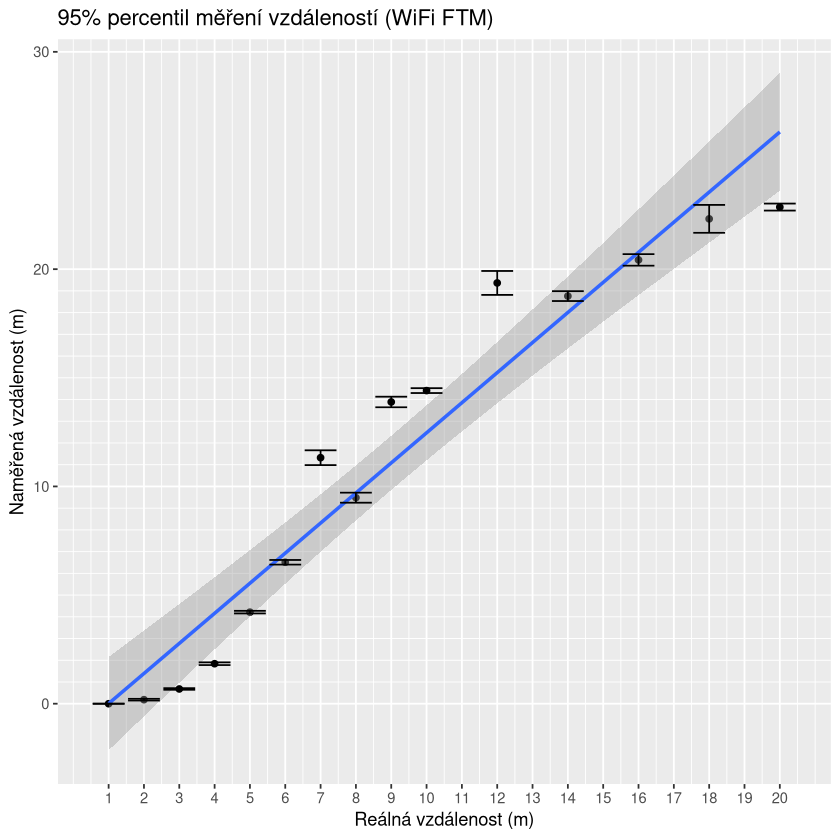

In [7]:
data_sd %>%
  ggplot(aes(x=measurement_dist, y=mean_dist_est)) +
  geom_point() +
  geom_smooth(method="lm") +
  geom_errorbar(aes(x=measurement_dist, ymin = (mean_dist_est - delta), ymax = (mean_dist_est + delta))) +
  scale_y_continuous(minor_breaks = 1:20) +
  scale_x_continuous(breaks = 1:20) +
  ggtitle("95% percentil měření vzdáleností (WiFi FTM)") +
  ylab("Naměřená vzdálenost (m)") +
  xlab("Reálná vzdálenost (m)")
ggsave("out/ftm_percentiles.pdf", height = 10, width = 15, units = "cm", dpi = 450, create.dir = TRUE)

Z grafů můžeme vidět, že měření vzdálenosti není přesné. První 3 metry to odhaduje skoro stejně, u dalších měření to je přesnější. Měření na 7, 9, 10 a 12 metrech jsou výjimkou. Většina měření vzdálenost naměří menší než skutečnou vzdálenost, ale u těchto měření je to výrazně větší než reálná vzdálenost. Je možné, že to je prostředím, kde se měření uskutečnili.

Můžeme se podívat na rozdělení chyby měření, jestli to je normální rozdělení nebo nějaké jiné.

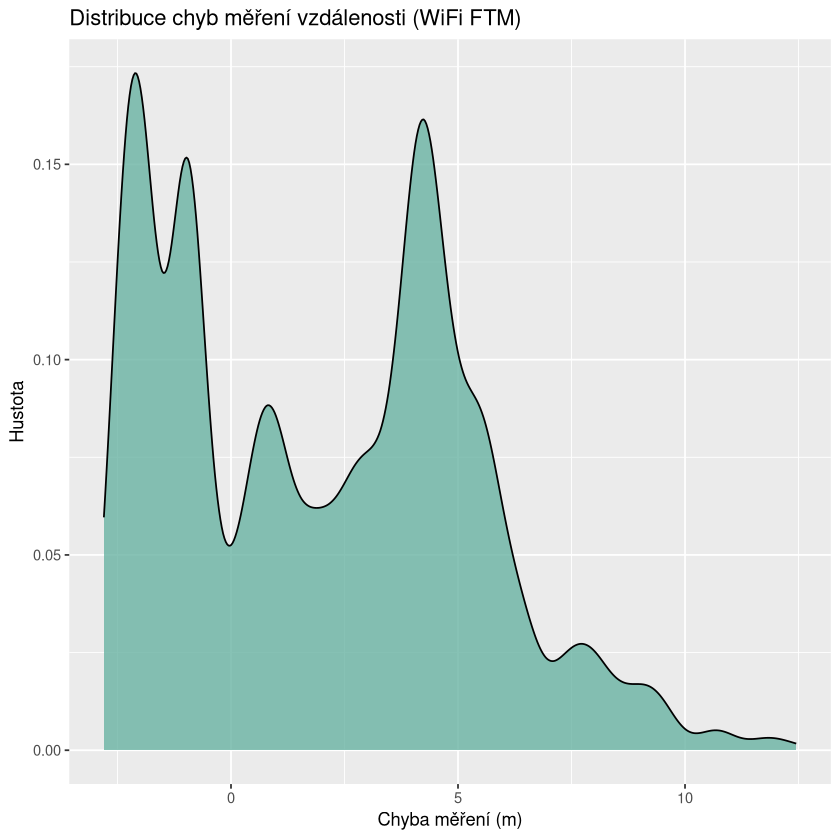

In [8]:
data_normalized_filtered <- filter(data_normalized, measurement_dist > 0)

ggplot(data_normalized, aes(x=dist_est_norm)) +
  geom_density(fill="#69b3a2",, alpha = .8, adjust = .5) +
  ggtitle("Distribuce chyb měření vzdálenosti (WiFi FTM)") +
  ylab("Hustota") +
  xlab("Chyba měření (m)") +
  labs(fill="Reálná vzdálenost")
ggsave("out/ftm_distribution.pdf", height = 10, width = 15, units = "cm", dpi = 450, create.dir = TRUE)

Z dat můžeme vidět, že rozdělení chyby měření je multi-modální.

Můžeme se také podívat, jestli je nějaký linární vztah mezi chybou měření a vzdáleností měření.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


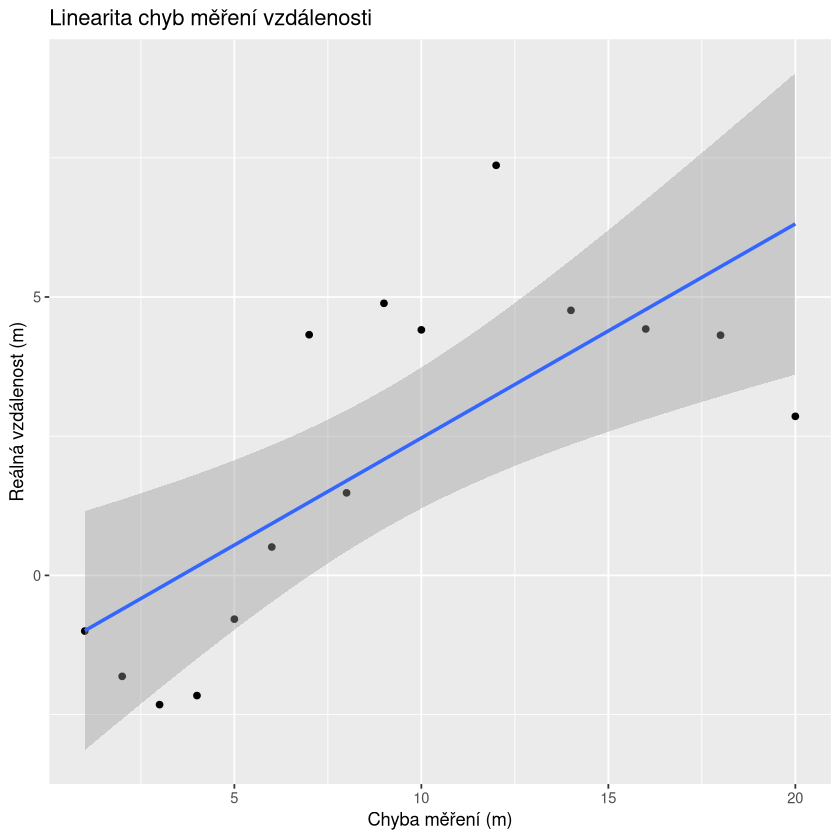

In [9]:
data_sd %>%
  ggplot(aes(x=measurement_dist, y=mean_dist_est - measurement_dist)) +
  geom_point() +
  geom_smooth(method="lm") +
  ggtitle("Linearita chyb měření vzdálenosti") +
  ylab("Reálná vzdálenost (m)") +
  xlab("Chyba měření (m)")
ggsave("out/ftm_linear_errors.pdf", height = 10, width = 15, units = "cm", dpi = 450, create.dir = TRUE)

Můžeme vidět, že se chyba měření není nijak předvídatelná. Tento typ měření je vhodný pouze na odhad vzdálenosti typu je zařízení blízko nebo daleko. Je možné, že při větších vzdálenostech bude měření přesnější, ale neměl jsem možnost to otestovat.


Ještě se podíváme na lineární regresy mezi reálnou a průměrnou naměřenou vzdáleností. Nulová hypotéza: mezi reálnou a naměřenou vzdáleností není lineární vztah.


Call:
lm(formula = measurement_dist ~ mean_dist_est, data = data_sd)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.59375 -0.88026  0.08941  0.85893  3.04808 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.51371    0.67945   2.228   0.0442 *  
mean_dist_est  0.67544    0.04932  13.696 4.22e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.563 on 13 degrees of freedom
Multiple R-squared:  0.9352,	Adjusted R-squared:  0.9302 
F-statistic: 187.6 on 1 and 13 DF,  p-value: 4.217e-09


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


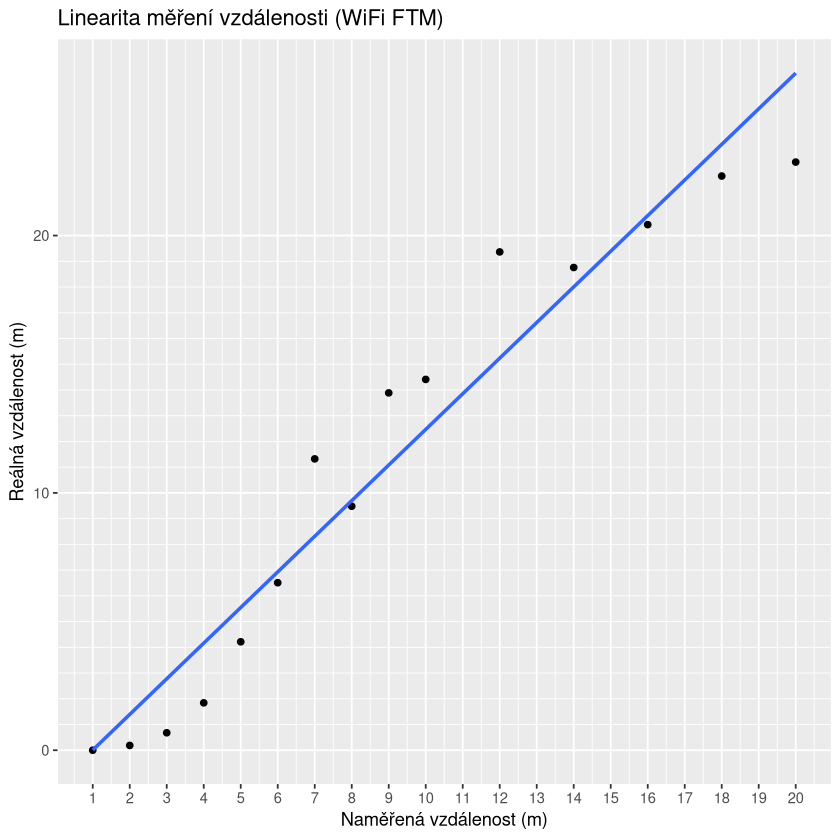

In [10]:
model <- lm(measurement_dist ~ mean_dist_est, data = data_sd)
summary(model)

data_sd %>%
  ggplot(aes(x=measurement_dist, y=mean_dist_est)) +
  geom_point() +
  geom_smooth(method="lm", se=FALSE) +
  scale_y_continuous(minor_breaks = 1:20) +
  scale_x_continuous(breaks = 1:20) +
  ggtitle("Linearita měření vzdálenosti (WiFi FTM)") +
  ylab("Reálná vzdálenost (m)") +
  xlab("Naměřená vzdálenost (m)")
ggsave("out/ftm_linear_model.pdf", height = 10, width = 15, units = "cm", dpi = 450, create.dir = TRUE)

In [11]:
model$coefficients

(Intercept) mean_dist_est 
    1.5137068     0.6754358

p-hodnota je pod standardní hladině významnosti 0.05, takže můžeme nulovou hypotézu zamítnout.